In [2]:
from langgraph.graph import StateGraph,END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults

In [3]:
tool=TavilySearchResults(max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],operator.add]

In [38]:
from langgraph.checkpoint.sqlite import SqliteSaver

# Manually enter context manager
memory_context = SqliteSaver.from_conn_string(":memory:")
memory = memory_context.__enter__()

In [39]:
class Agent:
    def __init__(self,model,tools,checkpointer,system=""):
        self.system=system
        graph=StateGraph(AgentState)
        graph.add_node("llm",self.call_groq)
        graph.add_node("action",self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.action_exists,
            {True:"action",False:END}
        )
        graph.add_edge("action","llm")
        graph.set_entry_point("llm")
        self.graph=graph.compile(checkpointer=checkpointer)
        self.tools={t.name:t for t in tools}
        self.model=model.bind_tools(tools)
        
    def action_exists(self,state:AgentState):
        result=state['messages'][-1]
        return len(result.tool_calls)>0
        
        
    def call_groq(self,state:AgentState):
        messages=state["messages"]
        if self.system:
            messages=[SystemMessage(content=self.system)] + messages
        message=self.model.invoke(messages)
        return {'messages':[message]}
    
    def take_action(self,state:AgentState):
        tool_calls=state['messages'][-1].tool_calls
        results=[]
        for t in tool_calls:
            print(f'Calling: {t}')
            result=self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t["id"],name=t["name"],content=str(result)))
        print("Back to the Model !!")
        return {"messages":results}
    

In [40]:
prompt = """You are a smart research assistant. Use the search engine to help answer user questions.
You are allowed to make multiple calls (either together or in sequence).
Only look up information when you are sure of what you want.
If you need to look up some information before asking a follow-up question, do so.
Be efficient and clear in your responses."""

tools=[tool]
abot=Agent(ChatGroq(model='llama3-8b-8192'),tools=tools,checkpointer=memory,system=prompt)

In [41]:
messages=[HumanMessage("What is the weather in varanasi ?")]

In [ ]:
thread={'configurable':{'thread_id':'1'}}

In [43]:
for event in abot.graph.stream({"messages":messages},thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6q03', 'function': {'arguments': '{"query":"weather in Varanasi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 1021, 'total_tokens': 1102, 'completion_time': 0.0675, 'prompt_time': 0.131907609, 'queue_time': 0.021419705999999983, 'total_time': 0.199407609}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a0cb76cb-838e-4e78-845c-e3635baad322-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Varanasi'}, 'id': 'call_6q03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1021, 'output_tokens': 81, 'total_tokens': 1102})]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Varanasi'}, 'id': 'call_6q03', 'type': 'tool_call'}
Back to the Model !!
[ToolMessage(content='[{\'title\': \'

In [44]:
messages=[HumanMessage("What about in greater noida ?")]
for event in abot.graph.stream({"messages":messages},thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3shp', 'function': {'arguments': '{"query":"weather in Greater Noida"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 2314, 'total_tokens': 2361, 'completion_time': 0.039166667, 'prompt_time': 0.287956092, 'queue_time': 0.024051564000000025, 'total_time': 0.327122759}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2cb779ae-53f9-4c0f-a478-58c64905e37e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Greater Noida'}, 'id': 'call_3shp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2314, 'output_tokens': 47, 'total_tokens': 2361})]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Greater Noida'}, 'id': 'call_3shp', 'type': 'tool_call'}
Back to the Model !!
[ToolMessage(cont

In [45]:
messages=[HumanMessage("Which one is warmer ?")]
for event in abot.graph.stream({"messages":messages},thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content="Varanasi is warmer, with a temperature of 41.4°C (106.5°F), compared to Greater Noida's temperature of 36.1°C (97.0°F).", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 2971, 'total_tokens': 3013, 'completion_time': 0.035, 'prompt_time': 0.372501387, 'queue_time': 0.027672001, 'total_time': 0.407501387}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None}, id='run-62db513b-ab18-4213-9929-2aecb65c17ee-0', usage_metadata={'input_tokens': 2971, 'output_tokens': 42, 'total_tokens': 3013})]


In [ ]:
messages=[HumanMessage("Which one is warmer ?")]
# we use graph.stream and not graph.invoke to stream
for event in abot.graph.stream({"messages":messages},{'configurable':{'thread_id':'2'}}):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ntv8', 'function': {'arguments': '{"query":"temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 2056, 'total_tokens': 2126, 'completion_time': 0.058333333, 'prompt_time': 0.256251626, 'queue_time': -0.349556786, 'total_time': 0.314584959}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8921f888-70d1-4d65-8799-17a702ea3124-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'temperature'}, 'id': 'call_ntv8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2056, 'output_tokens': 70, 'total_tokens': 2126})]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'temperature'}, 'id': 'call_ntv8', 'type': 'tool_call'}
Back to the Model !!
[ToolMessage(content="[{'title': 'Temperature | Definition, Scal

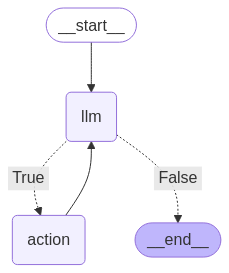

In [48]:
from IPython.display import Image
display(Image(abot.graph.get_graph().draw_mermaid_png()))

In [60]:
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
import aiosqlite
conn = await aiosqlite.connect(":memory:")
memory = AsyncSqliteSaver(conn)
await memory.setup()
abot=Agent(model=ChatGroq(model='llama3-8b-8192'),tools=tools,checkpointer=memory,system=prompt)

In [61]:
messages=[HumanMessage("What isthe weather in varanasi ?")]
thread={"configurable":{"thread_id":"3"}}
async for event in abot.graph.astream_events({"messages":messages},config=thread):
    kind=event["event"]
    if kind=="on_chat_model_stream":
        content=event['data']['chunk'].content
        if content:
            print(content,end='|')

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Varanasi'}, 'id': 'call_e3wb', 'type': 'tool_call'}
Back to the Model !!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Varanasi weather in April 2025'}, 'id': 'call_hxxs', 'type': 'tool_call'}
Back to the Model !!
The| weather| in| Var|an|asi| in| April| |202|5| is| expected| to| be| extremely| hot|,| with| temperatures| ranging| from| |28|°C| to| |42|°C|.| It| is| advisable| to| drink| plenty| of| water| regularly|.| There| may| be| a| few| rainy| days| during| the| month|,| but| the| weather| is| generally| comfortable|.|